In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

# Data exploration and preprocessing

In [3]:
!pip install -qq kaggle

In [4]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

compname = 'feedback-prize-english-language-learning'

if iskaggle: path = Path('../input/'+compname)
else:
    import zipfile,kaggle
    path = Path(compname)
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

df = pd.read_csv(path/'train.csv')
tst_df = pd.read_csv(path/'test.csv')
modes = df.mode().iloc[0]

feedback-prize-english-language-learning.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!ls {path}

models	sample_submission.csv  test.csv  train.csv


In [6]:
df.head(1)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.\n\nThe hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and st...",3.5,3.5,3.0,3.0,4.0,3.0


In [7]:
df.select_dtypes(include=[np.number]).sum(axis=1)

0       20.0
1       14.5
2       18.0
3       27.0
4       16.5
        ... 
3906    17.0
3907    22.5
3908    18.0
3909    26.0
3910    19.0
Length: 3911, dtype: float64

In [8]:
def proc_data(df):
    if not 'score' in df.columns:
        df['score'] = df.select_dtypes(include=[np.number]).sum(axis=1)

proc_data(df)
proc_data(tst_df)

In [9]:
df[:1]

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,score
0,0016926B079C,"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home.\n\nThe hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and st...",3.5,3.5,3.0,3.0,4.0,3.0,20.0


In [10]:
max_scored = df.score.idxmax()
max_scored

2389

In [11]:
print('Best overall essay:')
print(df.loc[max_scored].full_text)

Best overall essay:
I agree with Michelangelo's statement as I have found through experience that it benefits me more to set high expectations and not reach my goal, rather than settling on a low goal and achieving it. When setting high goals, I find that I learn more and progress my abilties further than I do with a lower goal. This is because setting high goals requires confidence, challenges, and pride.

Firstly, hard work is required to achieve high goals, and requires confidence. Confidence involves having trust and believing that you are capable of accomplishing something. I have found that when I set high goals, I feel more confident in my abilities. With lower goals however, my confidence is lower as I settle for the easier path and do not trust myself to do better. With a higher aim, my confidence motivates me to not give up. I tend to try harder, and always believe in myself. For example, at school, I had to choose whether I wanted to try out for the varsity tennis team or re

In [12]:
# let's check for missing data
df.isna().sum(axis=0)

text_id        0
full_text      0
cohesion       0
syntax         0
vocabulary     0
phraseology    0
grammar        0
conventions    0
score          0
dtype: int64

In [13]:
list(df.columns)

['text_id',
 'full_text',
 'cohesion',
 'syntax',
 'vocabulary',
 'phraseology',
 'grammar',
 'conventions',
 'score']

In [14]:
# let's see general training set statistics
df.columns

Index(['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary',
       'phraseology', 'grammar', 'conventions', 'score'],
      dtype='object')

# Let's create a basic text learner

In [15]:
from fastai.text.all import *

In [16]:
dls = TextDataLoaders.from_df(df, path, text_col='full_text', label_col='cohesion')

In [17]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [18]:
learn.lr_find()

KeyboardInterrupt: 

In [ ]:
learn.fine_tune(5, 1e-2)

In [30]:
learn.show_results()

,text,category,category_
0,"xxbos i am agree with the xxmaj waldo xxmaj emerson 's prompt . xxmaj he wrote that "" to be yourself in a world that is constantly trying to make you something else is the greatest accomplishment . "" \n\n "" never give up . "" xxmaj this word xxunk our xxunk about our thought . xxmaj it makes us xxunk . xxmaj life is not a bed of rose , life is struggle . xxmaj every single person has their life struggle . xxmaj nobody is a perfect at they look . a perfect man is he who win the struggle . a successful man , he not get success in a second . xxmaj he had lot of struggle in his life , but he do n't stop for his goal . xxmaj after long time keep trying made him successful . xxmaj he adjust the struggle and",3.5,3.0
1,"xxbos xxmaj in the principals office there is quote stating that "" your life can be beneficial if your doing something very productive , because it can lead you to great success in life "" xxmaj in some way we ask ourselves if we are do something with our lives and be thinking ahead on what we want to do with our life and what can take us to success . xxmaj is that true ? . xxmaj its more than just having something to do . xxmaj life is very short , xxmaj as long as you are doing something with success . xxmaj living is an option as well as just giving up and not trying very enough . xxmaj accomplishing something in life to any dream you want to have . xxmaj if you do nt try as hard in life , you will never succeed and",2.5,4.0
2,"xxbos xxmaj if we think about the words that the xxmaj british xxmaj prime xxmaj minister xxmaj wiston xxmaj churchill xxunk "" succes consists of going from failure to failure without loss of enthusiasm . "" xxmaj there is a lot of truth is this words well that is what i believe . xxmaj so how important is the role that failure plays in the process to reach success and do n't loss enthusiasm in the proccess ? xxmaj in my opinion it is very important because it make us gain experience , improve our skills , and it make you feel comfortable and happy at the end . \n\n xxmaj xxunk think about how you feel when your staring in the proccess to reach a new goal that you propose to youself it could be hard at the begin , because is your first time in that enviroment and",2.5,3.0
3,"xxbos a lot of people accomplish more if they are always doing something and others ask if inactivity also serve as a purpose . xxmaj there is a lot of people doing a lot of activities everyday and some others doing nothing than just watch xxup tv . xxmaj each human person in the world have a purpose , goal to get in a future and is something that we really want to have in our life . xxmaj xxunk purposes do n't come by itself as a miracle . xxmaj every person has a different purpose , some purposes are complicated to reach , and there 's also some less complicated but does n't make any difference because every person decides and picks what are their purposes and whether if they give up or they do anything to reach them . xxmaj thomas xxmaj jefferson wrote "" determine never",2.5,3.5
4,"xxbos i feel that working with a partner is more beneficial to students . xxmaj working with partners gets students extra help when in need . xxmaj it can make new friends while working on big projects . xxmaj also it makes the work get done easier and quicker when working in big groups . i also personally think that any project with a presentation should be a group project . xxmaj if that presentation has more than just the presentation it should be a three person group . \n\n xxmaj working with a partner is beneficial to students , because it gives extra support or help on a project or classwork . xxmaj if a project is too big and impossible for one person to complete they could split up the work . xxmaj for example , when i had a final project in my english class ; i",3.5,3.5
5,"xxbos xxmaj have you ever accomplished something in your life ? xxmaj because people nowadays are very lazy and hard headed bec

In [31]:
preds, actuals, decoded = learn.get_preds(with_decoded=True)

tensor([[1.9430e-04, 6.2074e-04, 9.1341e-02,  ..., 2.4960e-02, 8.3245e-04,
         2.5042e-04],
        [8.4127e-04, 7.8517e-04, 2.9472e-02,  ..., 1.3126e-01, 1.1550e-02,
         2.0622e-03],
        [1.2204e-03, 3.3743e-03, 5.5332e-03,  ..., 3.9556e-01, 1.0615e-01,
         7.2997e-03],
        ...,
        [1.0341e-04, 1.7530e-04, 2.6497e-03,  ..., 4.7920e-01, 3.2254e-02,
         3.7362e-03],
        [1.6273e-03, 1.8583e-03, 2.4582e-02,  ..., 3.4170e-01, 4.8943e-02,
         7.9467e-03],
        [1.8655e-04, 2.3037e-03, 5.0473e-01,  ..., 1.0312e-03, 3.7424e-05,
         1.4505e-05]])

In [33]:
preds[0].shape

torch.Size([9])

## let's use a transformer now

In [20]:
# gpu memory management
import gc, torch
!pip install -Uqq pynvml

def free_gpu():
    gc.collect()
    torch.cuda.empty_cache()
    
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    free_gpu()

In [21]:
!pip install -Uqq transformers
!pip install -Uqq ohmeow-blurr

In [22]:
import os, warnings

import torch
from transformers import *
from transformers.utils import logging as hf_logging
from fastai.text.all import *

from blurr.text.data.all import *
from blurr.text.modeling.all import *

warnings.simplefilter("ignore")
hf_logging.set_verbosity_error()

os.environ["TOKENIZERS_PARALLELISM"] = "false"

/usr/local/lib/python3.9/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [23]:
labels = df["cohesion"].unique()
labels

array([3.5, 2.5, 3. , 4.5, 4. , 2. , 1. , 5. , 1.5])

In [24]:
n_labels = len(labels)
n_labels

9

In [37]:
report_gpu()

GPU:0
process       2704 uses     1475.000 MB GPU memory


In [38]:
model_cls = AutoModelForSequenceClassification

pretrained_model_name = "distilbert-base-uncased"

config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = n_labels

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
    pretrained_model_name,
    model_cls=model_cls, 
    config=config
)

In [39]:
blocks = (
    TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), 
    CategoryBlock
)
dblock = DataBlock(
    blocks=blocks, 
    get_x=ColReader("full_text"), 
    get_y=ColReader("cohesion"), 
    splitter=RandomSplitter(valid_pct=0.2)
)

dls = dblock.dataloaders(df, bs=32)
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=250)

,text,target
0,"success consist of going from failure to failure withouth loss of enthusiasm, and i'm agree with this statement, because can do what it wants if try and try, and everything is doing with effort, and than a failure can be for a better oportunity in th",3.0
1,"generic _ name march 18 2019 writting sol grade 8 before, i would always like to try and play the guitar. my brother would always try and teach me, everytime i hear the guitar, it makes me feel calmed. also when i was in elementary school, i used to",3.0


In [40]:
model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam, decouple_wd=True),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy, error_rate],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter,
)

SuggestedLRs(minimum=0.0002511886414140463, steep=0.00013182566908653826, valley=5.248074739938602e-05)

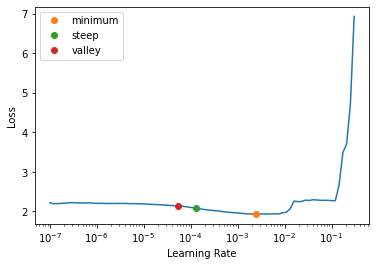

In [41]:
learn.lr_find(suggest_funcs=(minimum, steep, valley))

In [48]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.641724,1.559415,0.320972,0.679028,00:50


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.508509,1.627656,0.301790,0.698210,01:02
1,1.474431,1.461606,0.349105,0.650895,01:01
2,1.385645,1.439419,0.351662,0.648338,01:02
3,1.147156,1.598275,0.335038,0.664962,01:01
4,0.923578,1.703534,0.352941,0.647059,01:02
